# im2latex(S): Data Binning

&copy; Copyright 2017 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# What This Program Does
This notebook curates the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset).

* This notebook loads the data set which are png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode)
* Checks and visualizes the data
* Curates the data - whitening etc.
* Converts it to numpy arrays and finally stores it as pickle files.

----
## 'Binning' Training Data by Markup Sequence Length
Next, we'll group the samples by length of the (tokenized) latex formulas. The idea is to standardize the sequence lengths to a small set of fixed lengths (by padding smaller neighboring sequences with a 'null' tokens at the end.). This will allow us to create equal length batches for RNN/LSTM training while minimizing wasted training cycles. The [Show, Attend and Tell paper](https://www.semanticscholar.org/paper/Show-Attend-and-Tell-Neural-Image-Caption-Generati-Xu-Ba/146f6f6ed688c905fb6e346ad02332efd5464616) suggests this approach. At every epoch, we'll randomly/uniformly draw batches from within each group. Then we'll randomize said batch-list and use it for the training epoch. At next epoch, we'll repeat the process. The larger our group-size, that much better randomness we'll get in the training sequence. However the downside of increasing group-size is more padding of sequence-lengths resulting in wasteful  (and worse; maybe even misleading) training cycles.

-----

In [1]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160
data_folder = '../data/generated2'
image_folder = os.path.join(data_folder,'formula_images')

In [3]:
df_pruned = pd.read_pickle(os.path.join(data_folder, 'df_pruned.pkl'))

In [4]:
df_pruned[['width', 'word2id_len', 'height']].corr()

,width,word2id_len,height
width,1.000000,0.789018,0.218565
word2id_len,0.789018,1.000000,0.377885
height,0.218565,0.377885,1.000000


From the above correlation table we can clearly see the impact of pruning the outlier sampples from our dataset: the correlation of word2id_len went up from ~0.69 (for dff_all) to ~0.79 (for df_pruned).

In [5]:
display(df_pruned.word2id_len.quantile((.85,.90,.95,.96,.97,.98,.985,.99,1.0)))

0.850     96.0
0.900    106.0
0.950    120.0
0.960    124.0
0.970    128.0
0.980    134.0
0.985    137.0
0.990    141.0
1.000    150.0
Name: word2id_len, dtype: float64

**Below is what the sequence length distribution looks like at this point**

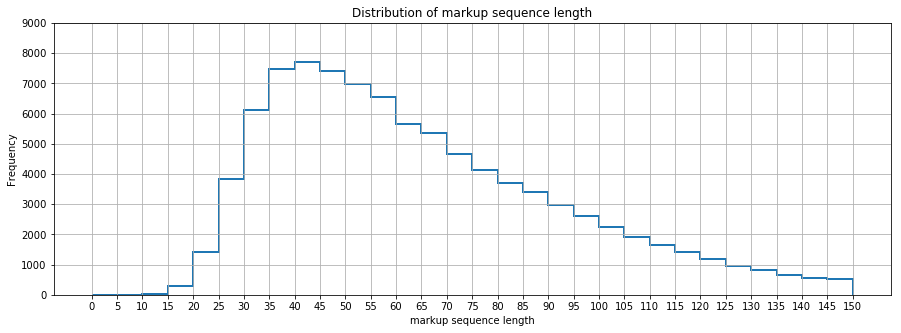

In [6]:
axes = plt.axes()
axes.set_xlabel('markup sequence length')
axes.set_title('Distribution of markup sequence length')
bins=range(0,151,5)
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins, xticks=bins, yticks=range(0,9001,1000))

### Hyperparameter: Data Bins
Below we create the data-bins as described at the beginning of this section. This 'binning' is a training hyperparameter.

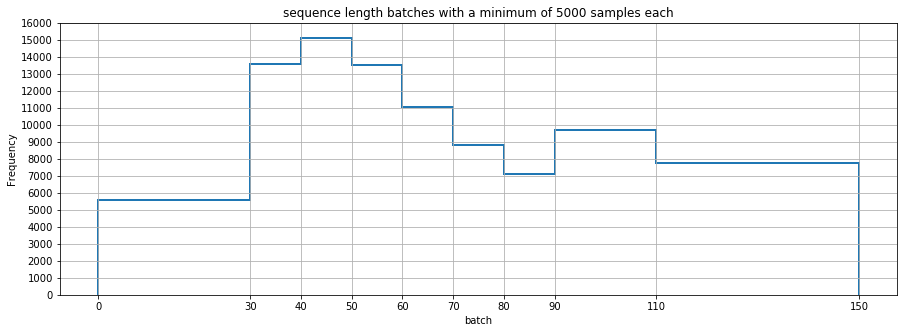

In [7]:
axes = plt.axes()
axes.set_xlabel('batch')
axes.set_ylabel('batch-count')
axes.set_title('sequence length batches with a minimum of 5000 samples each')
HYPER_bins=[0,30,40,50,60,70,80,90,110,150]
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=HYPER_bins, xticks=HYPER_bins, yticks=range(0,16001,1000))

In [8]:
bins=HYPER_bins
labels=np.array(bins[1:]) + 1 #Add 1 for ensuring minimum one 'null' token at the end of sequence.
cats = pd.cut(df_pruned.word2id_len, bins, labels=labels)
df_bins = df_pruned.assign(bin_len=cats)[['image', 'height', 'width', 'word2id_len', 'bin_len', 'word2id', 'latex_ascii' ]]
df_bins.head()

,image,height,width,word2id_len,bin_len,word2id,latex_ascii
0,450f7c1496143fd_basic.png,78,738,112,151,"[257, 524, 552, 13, 212, 554, 523, 256, 1, 529, 537, 60, 26, 1, 552, 410, 1, 530, 554, 523, 552,...",\int_{-\epsilon}^\infty dl\: {\rm e}^{-l\zeta} \int_{-\epsilon}^\infty dl' {\rm e}^{-l'\zeta} ll...
1,868d5037af9e4b4_basic.png,94,962,125,151,"[529, 544, 523, 552, 18, 554, 1, 29, 1, 8, 17, 1, 13, 1, 552, 542, 528, 540, 544, 474, 364, 1, 5...",ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\the...
2,af0b6c3ee18804a_basic.png,87,291,47,51,"[517, 231, 524, 552, 410, 1, 533, 540, 541, 531, 554, 430, 454, 524, 552, 539, 30, 16, 554, 517,...",\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\widetilde{G}_n{(-a)^n\over2^{2n-1}}\label{H4}
3,dda45eca6d32fa3_basic.png,35,405,53,61,"[8, 552, 159, 1, 44, 554, 524, 526, 1, 532, 9, 524, 552, 534, 535, 554, 1, 29, 1, 16, 12, 1, 60,...","({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H)_{ijk} = 0 ,"
4,67eb249ed1c20d2_basic.png,60,521,69,71,"[51, 524, 552, 544, 545, 526, 545, 554, 1, 29, 1, 18, 377, 1, 446, 552, 46, 524, 21, 523, 552, 8...",S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^{(3)}} \left(\sqrt{n} +\sqrt{\bar{n}}\right)\label...


In [9]:
df_bins.groupby('bin_len').count()

,image,height,width,word2id_len,word2id,latex_ascii
bin_len,,,,,,
31,6608,6608,6608,6608,6608,6608
41,14032,14032,14032,14032,14032,14032
51,15042,15042,15042,15042,15042,15042
61,13341,13341,13341,13341,13341,13341
71,10858,10858,10858,10858,10858,10858
81,8598,8598,8598,8598,8598,8598
91,6900,6900,6900,6900,6900,6900
111,9480,9480,9480,9480,9480,9480
151,7424,7424,7424,7424,7424,7424


In [10]:
def get_padded(df_):
    df = df_[['bin_len', 'word2id_len', 'word2id']]
    def pad(row_ar):
        word2id = row_ar[2]
        plen = (0, row_ar[0]-row_ar[1])
        return np.pad(word2id, plen, 'constant', constant_values=0).tolist()
    padded_seq = df.apply(pad, raw=True, reduce=True, axis=1)
    return df_.assign(padded_seq=padded_seq, padded_seq_len=padded_seq.str.len())

In [11]:
df_binned = get_padded(df_bins)
assert sum(df_binned.padded_seq.str.len() != df_binned.bin_len) == 0
assert sum(df_binned.padded_seq_len != df_binned.bin_len) == 0

In [12]:
df_binned.to_pickle(os.path.join(data_folder, 'df_binned.pkl'))